In [147]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt

reload()
# !pip install matplotlib-venn

In [188]:
from snowballing.models import Work

class Metakey(object):
    
    def __rmatmul__(self, x):
        if hasattr(x, '__iter__'):
            return [y @ self for y in x]
        return x.metakey

class MetakeyTitle(object):
    
    def __rmatmul__(self, x):
        if hasattr(x, '__iter__'):
            return [y @ self for y in x]
        return "{0.metakey} - {0.name}".format(x)

    
metakey = Metakey()
metakey_title = MetakeyTitle()

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    for work in state.related - state.find("s0").related:
        backward |= (set(strategy.ref[work]) & state.related)
        forward |= (set(strategy.rev_ref[work]) & state.related)
    return backward, forward

#busca("scopus", seed=["wohlin2014a", "briand2000a"], filter_function=lambda x: True)
#busca("scopus", filter_function=lambda x: False)

### Snowballing - Busca via FS e BS no Artigo mais Citado (Seed Set = 1)

Não realiza busca em DL.
Realiza uma busca, via Forward e/ou via Backward para encontrar artigos do seed set no artigo mais citado, exemplo, mendes2004a.

### Forward

In [64]:
### Delta Related = Conector do nó
strategy = Strategy({work_by_varname("mendes2004a")})
strategy.forward().delta_related

{Building software cost estimation models using homogenous data,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [65]:

{x.metakey for x in strategy.backward().visited}


{'briand1999a',
 'briand2000a',
 'christodoulou2000a',
 'cook1977a',
 'jeffery2000a',
 'jeffery2001a',
 'kemerer1987a',
 'kitchenham1984a',
 'kitchenham1998a',
 'kitchenham2001a',
 'kitchenham2004a',
 'maxwell2002a',
 'mendes2003a',
 'mendes2003b',
 'mendes2004a',
 'shepperd2001a',
 'wieczorek2002a',
 'wilcoxon1945a'}

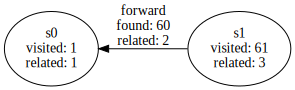

In [66]:
### Grafo
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.forward()

In [67]:
### Related do S1
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.forward().related

{Building software cost estimation models using homogenous data,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 Further comparison of cross-company and within-company effort estimation models for web applications}

### Backward

In [68]:
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.backward().delta_related

{A comparison of cross-company and within-company effort estimation models for web applications}

In [69]:
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.backward().visited

{An empirical validation of software cost estimation models,
 Assessment and comparison of common software cost estimation modeling techniques,
 A replicated assessment and comparison of common software cost modeling techniques,
 A procedure for analyzing unbalanced datasets,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 What accuracy statistics really measure,
 How valuable is company-specific data compared to multi-company data for software cost estimation?,
 Using public domain metrics to estimate software development effort,
 WWW2000: The Developer's view and a practitioner's approach to Web Engineering,
 Using simulation to evaluate prediction techniques,
 Applied statistics for software managers,
 Individual comparisons by ranking methods,
 A comparative study of two software development cost modeling techniques using multi-organizational and company-specific data,
 A comparison of cross-company and within-company effort e

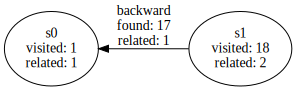

In [70]:
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.backward()

In [71]:
strategy = Strategy({work_by_varname("mendes2004a")})
State.last_id = 0
strategy.backward().name

's1'

### Snowballing - Forward and Backward - Union (N vezes)

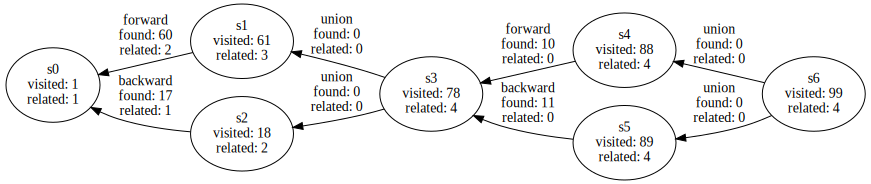

In [72]:
State.last_id = 0
state = strategy.sfbu()
state

In [73]:
len(state.visited - state.find("s0").visited)

98

In [74]:
state.related - state.find("s0").related

{Building software cost estimation models using homogenous data,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 A comparison of cross-company and within-company effort estimation models for web applications}

In [75]:
print("Relacionados:")
state.find("s5").delta_visited

Relacionados:


{How to find relevant data for effort estimation?,
 Exploiting the essential assumptions of analogy-based effort estimation,
 Statistical power analysis for the behavioral sciences,
 Software engineering metrics and models,
 A study of project selection and feature weighting for analogy based software cost estimation,
 Case studies for method and tool evaluation,
 Web cost estimation and productivity benchmarking,
 Local vs. global models for effort estimation and defect prediction,
 On the relative value of cross-company and within-company data for defect prediction,
 Comparison of Web size measures for predicting Web design and authoring effort,
 The need for web engineering: An introduction}

In [76]:
print("Relacionados:")
state.find("s5").delta_visited - state.find("s5").delta_visited

Relacionados:


set()

In [77]:
state.find("s4").related

{Building software cost estimation models using homogenous data,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 A comparison of cross-company and within-company effort estimation models for web applications,
 Further comparison of cross-company and within-company effort estimation models for web applications}

In [78]:
print("Relacionados:")
state.find("s4").delta_visited

Relacionados:


{From Function Points to COSMIC-A Transfer Learning Approach for Effort Estimation,
 An empirical analysis of data preprocessing for machine learning-based software cost estimation,
 La práctica de la estimación en empresas y áreas de Sistemas,
 Mining app stores: Extracting technical, business and customer rating information for analysis and prediction,
 Sharing data and models in software engineering,
 Empirical Assessment of Machine Learning Models for Effort Estimation of Web-based Applications,
 A comparison of cross-versus single-company effort prediction models for web projects,
 An Empirical Analysis of Three-Stage Data-Preprocessing for Analogy-Based Software Effort Estimation on the ISBSG Data,
 Systematic literature review on effort estimation for Open Sources (OSS) web application development,
 Effort estimation of web-based applications using machine learning techniques}

In [120]:
print("Visitados:")
state.find("s0").visited

Visitados:


{Cross-vs. within-company cost estimation studies revisited: an extended systematic review,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 A comparative study of two software development cost modeling techniques using multi-organizational and company-specific data,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 Using public domain metrics to estimate software development effort}

In [80]:
#Visualização de Backward
#state.related & set(strategy.ref[work_by_varname("mendes2004a")])

state.find("s0").related & set(strategy.ref[work_by_varname("mendes2004a")])

set()

## Estratégias

### Estratégia 1 - Busca em todas Digital Libraries (DL)

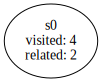

In [81]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

state = strategy
strategy.initial

#strategy.initial.name

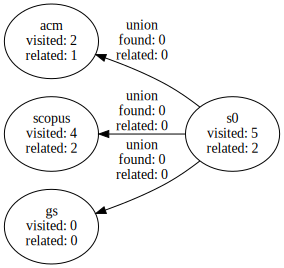

In [82]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0")
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["acm", "scopus", "gs"], filter_function)
#strategy.initial.find("acm")
strategy.initial

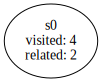

In [83]:
reload()
TOTAL = [x for _, x in load_work_map_all_years() if x.category == "snowball"]
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

state = strategy.initial
strategy.initial.visited
state

In [84]:
array = []

name = "E1"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E1
0.5
Recall E1
0.5


In [85]:
len ([x for _, x in load_work_map_all_years() if x.category == "snowball"])

4

### Estratégia 2 - Busca em todas Digital Libraries + Snowballing (Guideline - sfbu)

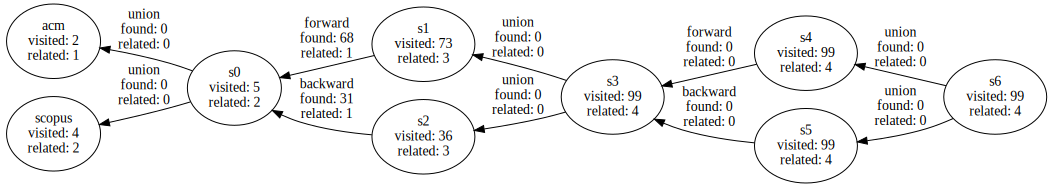

In [104]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm", "scopus"], filter_function)
#Strategy(*busca("acm","scopus", filter_function=filter_function))

state = strategy.sfbu()
#state = strategy.bbff()
#state = strategy.ffbb()
#state = strategy.s2ffbb2u()

state

In [180]:
separa_backward_forward(state) @ metakey_title

[['kitchenham2004a - A comparison of cross-company and within-company effort estimation models for web applications'],
 ['premraj2007a - Building software cost estimation models using homogenous data']]

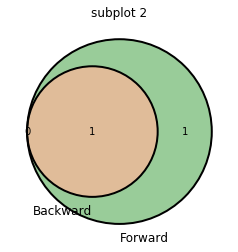

In [187]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('subplot 2')
plt.show()

In [186]:
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward ['mendes2004a']
Forward ['ferrucci2012a', 'mendes2004a']


In [140]:
x = v.get_patch_by_id('100')

In [141]:
x.set_linestyle = "black"

In [110]:
state.find("s0").related @ metakey

['ferrucci2012a', 'mendes2004a']

In [94]:
[x.metakey for x in state.find("s0").related]

['ferrucci2012a', 'mendes2004a']

In [95]:
diff_related = state.related - state.find("s0").related
[x.metakey for x in diff_related]

['premraj2007a', 'kitchenham2004a']

In [190]:
 descreve_delta(strategy, state, "s2")

backward ferrucci2012a
- kocaguneli2012a 
- kitchenham1998a 
- mendes2005b 
- mendes2008a 
- shepperd2001a 
- mendes2003a 
- cohen1988a 
- kocaguneli2010a 
- mendes2002a 
- menzies2011a 
- conte1986a 
- kitchenham2001a 
- mendes2007a 
- kitchenham1995a 
- kitchenham2007a 
- maxwell2002a 
- turhan2009a 
- kocaguneli2011a 
- cook1977a 
- li2009a 
- mendes2008b 
- kitchenham2004a related
- mendes2005a 
backward mendes2004a
- kemerer1987a 
- briand1999a 
- briand2000a 
- kitchenham1998a 
- kitchenham2001a 
- wieczorek2002a 
- kitchenham2004a related
- christodoulou2000a 
- shepperd2001a 
- maxwell2002a 
- wilcoxon1945a 
- kitchenham1984a 
- mendes2003b 
- cook1977a 
- mendes2003a 
forward mendes2004a
- mendes2007a 
- kocaguneli2010a 
- mendes2005b 
- kitchenham2007a 
- mendes2008b 


In [59]:
E2P = len (strategy.initial.related) / len (strategy.initial.visited)
#print (len (strategy.initial.related))
#print (len (strategy.initial.visited))
#print (E2P)
print ("Precision na Busca E2: %.2f%%" % E2P)

#print ("Precision no Snowballing - E2:")
#print(len(state.related - state.find("s0").related))
#print(len(state.visited - state.find("s0").visited))

E2PS = len(state.related - state.find("s0").related) / len(state.visited - state.find("s0").visited)

print ("\n""Precision no Snowballing E2: %.2f%%" % E2PS)

print("Precision no Snowballing E2 - Forward - 1 iteração: %.2f%%" % (len (state.find("s1").delta_related) / len (state.find("s1").delta_visited)))

print("Precision no Snowballing E2 - Backward - 1 iteração: %.2f%%" % (len (state.find("s2").delta_related) / len (state.find("s2").delta_visited)))

print("\n""Precision E2 (Busca + Snowballing): %.2f%%" % (len(state.related) / len(state.visited)))

#len (state.find("s1").related)

#len (state.find("s1").delta_related)
#len (state.find("s1").delta_visited)


name = "E2"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision na Busca E2: 0.40%

Precision no Snowballing E2: 0.02%
Precision no Snowballing E2 - Forward - 1 iteração: 0.01%
Precision no Snowballing E2 - Backward - 1 iteração: 0.03%

Precision E2 (Busca + Snowballing): 0.04%
Precision E2
0.04040404040404041
Recall E2
1.0


### Estratégia 3 - Busca Informal (Google Scholar) + Snowballing (Guideline - sfbu)

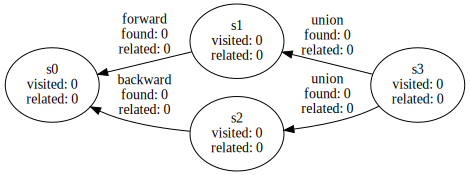

In [29]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
state

In [30]:
name = "E3"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E3


ZeroDivisionError: division by zero

### Estratégia 4 - Busca em Scopus + Snowballing (Guideline - sfbu)

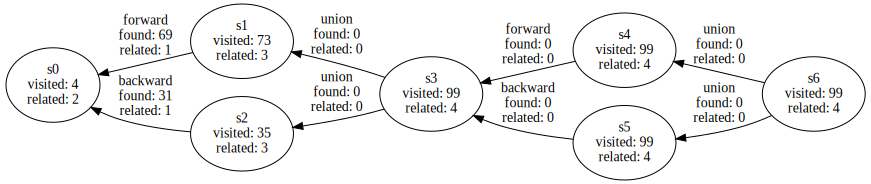

In [31]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.sfbu()
state

In [32]:
name = "E4"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E4
0.04040404040404041
Recall E4
1.0


In [33]:
state.find("s0").related

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [34]:
state.find("s2").related

{Further comparison of cross-company and within-company effort estimation models for web applications,
 A comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [35]:
state.find("s0").visited

{A comparative study of two software development cost modeling techniques using multi-organizational and company-specific data,
 Further comparison of cross-company and within-company effort estimation models for web applications,
 Using public domain metrics to estimate software development effort,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [36]:
# Com backward de mendes2004a é possível encontrar 2 (resultado da celula)
state.related & set(strategy.ref[work_by_varname("mendes2004a")])

{A comparison of cross-company and within-company effort estimation models for web applications}

In [37]:
# Com backward de ... em S2, encontrou 1 (resultado da celula)
state.find("s2").delta_related & set(strategy.ref[work_by_varname("mendes2004a")])

{A comparison of cross-company and within-company effort estimation models for web applications}

In [38]:
# Com forward de ... em S1, encontrou 1 (resultado da celula)
state.find("s1").delta_related & set(strategy.rev_ref[work_by_varname("mendes2004a")])

{Building software cost estimation models using homogenous data}

In [39]:
len(state.find("s1").delta_visited)

69

In [40]:
#len(state.find("s1").delta_visited & set(strategy.rev_ref[work_by_varname("mendes2004a")]))
# forward
len(set(strategy.rev_ref[work_by_varname("mendes2004a")]))

60

In [41]:
# backward
len(set(strategy.ref[work_by_varname("mendes2004a")]))

17

In [42]:
search_state = strategy.initial
search_state.related

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

### Estratégia 5 - Busca em Scopus + Snowballing (Short Paper - s2ffbb2u)

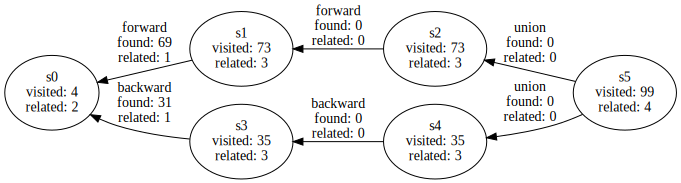

In [96]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.s2bbff2u()
state

In [63]:
name = "E5"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E5
0.04040404040404041
Recall E5
1.0


In [64]:
state.find("s0").related 

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [65]:
state.find("s1").related 

{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set,
 Building software cost estimation models using homogenous data}

In [66]:
state.find("s5").related 

{Web effort estimation: The value of cross-company data set compared to single-company data set,
 Building software cost estimation models using homogenous data,
 A comparison of cross-company and within-company effort estimation models for web applications,
 Further comparison of cross-company and within-company effort estimation models for web applications}

In [67]:
sx, sy = state.previous[0]

sx.related & sy.related


{Further comparison of cross-company and within-company effort estimation models for web applications,
 Web effort estimation: The value of cross-company data set compared to single-company data set}

In [46]:
sx.name

's2'

In [54]:
sy.name

's4'

### Estratégia 6 - Busca em Scopus + Snowballing (JF - bbff)

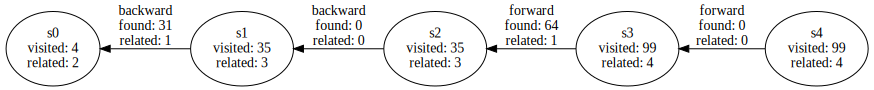

In [47]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.bbff()
state

In [48]:
name = "E6"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E6
0.04040404040404041
Recall E6
1.0


### Estratégia 7 - Busca em Scopus + Snowballing (JF - ffbb)

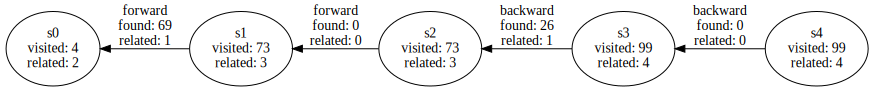

In [49]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.ffbb()
state

In [50]:
name = "E7"
print ("Precision " + name)
EP = len (state.related) / len (state.visited)
print (EP)
print ("Recall " + name)
ER = len (state.related) / len (TOTAL)
print (ER)

array.append((name, EP, ER))

Precision E7
0.04040404040404041
Recall E7
1.0


### Análise das Estratégias

In [51]:
%matplotlib notebook
import pandas as pd

In [52]:
df = pd.DataFrame (array,columns = ['Estratégia','Precision','Recall'])
df.index = df['Estratégia']
df

,Estratégia,Precision,Recall
Estratégia,,,
E1,E1,0.500000,0.5
E2,E2,0.040404,1.0
E4,E4,0.040404,1.0
E5,E5,0.040404,1.0
E6,E6,0.040404,1.0
E7,E7,0.040404,1.0


<IPython.core.display.Javascript object>


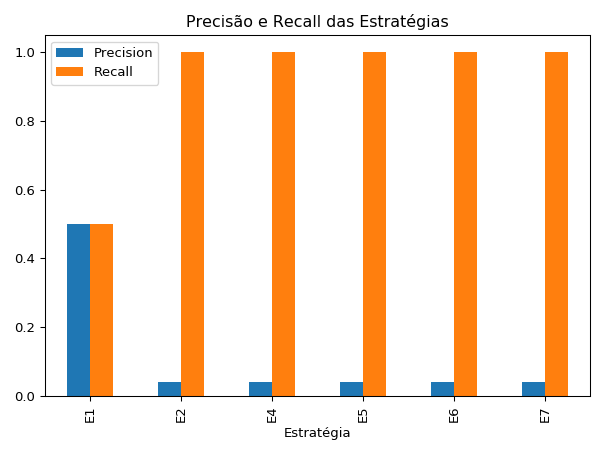

In [53]:
import matplotlib.pyplot as plt
ax = df.plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


## Antigo

In [ ]:

s5 = state.find("s5")
s5

In [ ]:
s5.delta_related

In [ ]:
state.previous[0][1].previous[0][0].related

In [ ]:
state

In [ ]:
s1 = state.find("s1")
total = sum(1 for _, w in load_work_map_all_years() if w.category == "snowball")

In [ ]:
len(s1.delta_related) / len(s1.delta_visited)

In [ ]:
len(s1.delta_related) / total

In [ ]:
len(state.related) / len(state.visited)

In [ ]:
len(state.related) / total

In [ ]:
state.log

In [ ]:
len(state.visited)

In [ ]:
with open("output/snowballing.provn", "w") as provn:
    provn.write(state.provn)

In [ ]:
!provconvert.bat -infile output/snowballing.provn -outfile output/snowballing.dot

In [ ]:
with open("output/snowballing.dot", "r") as prov_dot:
    text = prov_dot.read().replace('rankdir="BT";', 'rankdir="RL"; ranksep="0.1";')
with open("output/snowballing.dot", "w") as prov_dot:
    prov_dot.write(text)

In [ ]:
!dot -Tpng output/snowballing.dot -ooutput/snowballing.png
!dot -Tsvg output/snowballing.dot -ooutput/snowballing.svg
#!inkscape -D -z --file=output/snowballing.svg --export-pdf=output/snowballing.pdf

In [ ]:
from IPython.display import Image
Image("output/snowballing.png")

In [ ]:
log = state.log

In [ ]:
len([x for _, x in load_work_map_all_years() if x.category in ('snowball','ok','backward')])

In [ ]:
from fractions import Fraction
for step in log:
    print("precision", Fraction(step.new_related, step.new_references))

In [ ]:
len([x for x in state.visited if x.category in {"snowball"}])

In [ ]:
from snowballing.approaches import get_approaches
len(get_approaches())

In [ ]:
visited = state.visited
len([(x, x.year) for x in state.visited
     if x.category in {"nofile"}
     if x.place.name != "Tech Report"
     if x.place.name != "Book"
     if x.place.name != "Patent"
     if x.place.name == "Conference"
     if x.display != x.place.acronym
    ])
#count = 0
#for x in visited:
#     if hasattr(x, 'dglibrary'):
#        print(x.dglibrary)
#        count = 1 + count
#print (count)
len([
    (x, x.year) for x in visited
     if hasattr(x, 'dglibrary') and x.dglibrary=="Scopus"
    
])

def count_ref(library,obj):
    len_dglibrary = len([(x, x.year) for x in obj
                             if hasattr(x, 'dglibrary') and library in x.dglibrary  
                        ])
    len_backward = len([(x, x.year) for x in obj
                             if x.category=="backward"  
                        ])
    len_forward = len([(x, x.year) for x in obj
                             if x.category=="forward"  
                        ])
    qtdref=0
    qtdcitations=0
    for x in obj:
        qtdref=qtdref + int(getattr(x, "references", 0))
        
    scopus = sum(int(getattr(x, "scopus", 0)) for x in obj)
            
    for x in obj:
        qtdcitations=qtdcitations + int(getattr(x, "citations", 0))
    return len_dglibrary,qtdref,qtdcitations,len_backward,len_forward
     

print ("Digital Library, Referencias, Citações, Qtd Backward, Qtd Forward")
print(count_ref("Scopus",visited))

log

print (log[0].name, log[0].new_references)
print(log[1].name, log[1].new_references)
print(log[2].name, log[2].new_references)
print(log[3].name, log[3].new_references)
print("visitados", len(visited))

In [ ]:
len([x for x in visited if x.category in {"lang"}])

In [ ]:
len([x for x in visited if x.category in {"site"}])

In [ ]:
len([x for x in visited
     if x.place.name == "Tech Report"
    ])

In [ ]:
len([x for x in visited
     if x.place.name == "ESEM"
    ])

In [ ]:
{x.category for x in visited}

In [ ]:
[(x.year, x.authors, x.name, x.place.name, x.request) for x in visited
 if x.category in {"nofile"}
 if x.place.name != "Tech Report"
 if x.place.name != "Book"
 if x.place.name != "Patent"
 if x.display != x.place.acronym]

In [ ]:
len(_)